# w1dem.py 最新版
日付：2019/01/25<br>
## できること
1. 周波数領域<br>
    VMD<br>
    Loop
    Coincidentloop
    HMD
    HED
    Grounded wire
    Line source
    
2. 時間領域<br>
    VMD（インパルス、ステップ）
    Loop
    Coincidentloop
    HMD
    HED
    Grounded wire
    Line source
    

## 課題
    任意波形
　　精度検証(任意) 

In [530]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.special import erf
import math
get_ipython().run_line_magic('matplotlib', 'inline')
#matplotlib inline

In [531]:
EmB = {'x': 100,
       'y': 100,
       'z': 0,
       'bRes': np.array([100,100]),
       'dh': np.array([20]),
       'mu': np.array([1.2566e-06,1.2566e-06]),
       'mu1': 1.2566e-06,
       'epsrn': 8.854187817e-12,
       'hs': 0,
       'current':1,
       'vmd': 1,
       'rad': 100,
       'turns': 1,
       'srcpar':5,# 1:VMD, 2:Circular loop, 3:Coincident, 
                  # 4:HMD, 
                  # 5:HED ,6:grounded wire ,7:Line source
       'fdtd': 1,
       'dbdt': 1,
       # 1: Ex, 2: Ey, 3:Ez, 4:Hx, 5:Hy, 6:Hz
       'rComp': [1, 2, 3, 4, 5, 6],
       'temtype': 1,
       'tol': 1.0000e-12,
       'NB': 0,
       'BMAX': 0,
       'numF': 100,
       'SwHankel': 1,
       # Frechet mesh (only for srcpar == 5)
       'stepsize': 0.001,
       # wire parameter (only for srcpar == 6)
       'L' : 50, # 1/2 line length
       'N' : 100,# mesh(recomend under 100)
       #Lはラプラス変換の係数の個数。倍精度では12が最も精度が高いとされている
       'time_point':100,
       'LL':10}

EmB['f'] = np.logspace(-2, 6, EmB['numF'])
EmB['sigma'] = 1 / EmB['bRes']
EmB['r'] = np.sqrt(EmB['x']**2 + EmB['y']**2)
EmB['nLayer'] = len(EmB["bRes"]) + 1
# EmB["time"] = np.logspace(-10, -2, EmB["time_point"])

In [532]:
def em1dbasetdem(EmB):

        
#############################       
    x = EmB['x']
    y = EmB['y']
    z = EmB['z']
    bRes = EmB['bRes'] 
    dh = EmB['dh']
    mu = EmB['mu']
    mu1 = EmB['mu1']
    epsrn = EmB['epsrn'] 
    hs = EmB['hs']
    current = EmB['current']
    vmd = EmB['vmd']
    rad = EmB['rad'] 
    turns = EmB['turns']
    srcpar = EmB['srcpar']
    fdtd = EmB['fdtd']
    dbdt = EmB['dbdt'] 
    rComp = EmB['rComp']
    temtype = EmB['temtype']
    tol = EmB['tol']
    NB = EmB['NB'] 
    BMAX = EmB['BMAX']
    numF = EmB['numF']
    SwHankell = EmB['SwHankel']
    stepsize = EmB['stepsize'] 
    hs = EmB['hs']
    current = EmB['current']
    L = EmB['L']
    N = EmB['N'] 
    time_point = EmB['time_point']
    LL = EmB['LL']
    f = EmB['f']
    sigma = EmB['sigma'] 
    r = EmB['r']
    nLayer = EmB['nLayer']
 ##############################    
                            
    if srcpar in [1,2,3,4,5]:
        N = 1
    
#     if srcpar == 1 and r == 0:
#         r = 1e-2
    
#     if r != 0.0:
#         cosPhai = x / r
#         sinPhai = y / r
#     else:
#         cosPhai = 0
#         sinPhai = 0
        
    if srcpar in [1,4]:
        mom = vmd
    elif srcpar == 2:
        mom = current * turns
    elif srcpar == 3:
        mom = current * turns * turns
    elif srcpar in [5,6,7]:
        mom = current

    EmB['mom'] = mom

        
    h = np.zeros((1,nLayer-1))
    mu = np.ones((1,nLayer)) * mu1    
# define the index of receiver existing layer
    if z <= 0:  #(1) rLayer = 1
        rLayer = 1
        for ii in range (2,nLayer): #(2) 2 <= rLayer <= nLayer-1 
             h[0,ii-1] = h[0,ii-2] + dh[ii-2]
    else:
        rLayer = 19960524
 
    if nLayer == 2 and z > 0: #(1') rLayer = 2 
        rLayer = 2
    elif (nLayer >= 3) and (z > 0): 
        for ii in range(2,nLayer): #(2') 2 <= rLayer <= nLayer-1 
            h[0,ii-1] = h[0,ii-2] + dh[ii-2]
            if z >= h[0,ii-2] and z <= h[0,ii-1]:
                rLayer = ii   
    
    if rLayer == 19960524: #(3) rLayer = nLayer
        rLayer = ii + 1    
  
 # define the index of trasmitter existing layer
    if hs <= 0:  #(1) tLayer = 1
        tLayer = 1 
    else:
        tLayer = 19960524            
    if nLayer == 2 and hs > 0: #(2) tLayer = 2
        tLayer = 2
    elif (nLayer >= 3) and (hs > 0):
        h[0] = 0
        for ii in range(2,nLayer): #(2') 2 <= tLayer <= nLayer-1 
            h[0,ii-1] = h[0,ii-2] + dh[ii-2]
            if hs >= h[0,ii-2] and hs <= h[0,ii-1]:
                tLayer = ii  
    if tLayer == 19960524: #(3) tLayer = nLayer
        tLayer = ii + 1
    
    EmB['rLayer'] = rLayer
    EmB['tLayer'] = tLayer
    EmB['h'] = h    
            
# load linia filter data            
    if EmB["SwHankel"] == 1:
        #hankel241を読み込む
        print("filter is kong")
        matdata = scipy.io.loadmat("hankelset241.mat")
        EmB["filter_length"] = matdata["lamdaBase"].shape[0]
        wt0 = matdata["j0"]
        wt1 = matdata["j1"]
        lamdaBase = matdata["lamdaBase"]
        yBase = lamdaBase
        
    elif EmB["SwHankel"] == 2:
        print("filter is anderson")
        matdata = scipy.io.loadmat("anderson_801.mat")
        EmB["filter_length"] = matdata["yBase"].shape[0]
        wt0 = matdata["wt0"]
        wt1 = matdata["wt1"]
        lamdaBase = matdata["yBase"]
        yBase = lamdaBase
        
#     ePhai = np.zeros(numF, dtype=complex)
#     hR = np.zeros(numF, dtype=complex)

    
# Frequency domain or Time domain        
    if fdtd == 1:
# Frequency Domain (such as GEM2, valcan(MCSEM))
# compute E and H, 6 components(x,y,z) 
        DANS = np.zeros((numF, 6), dtype=complex)
        
        for iFrq in range(1, numF + 1):
            EmB["ii"] = 0
            emField = hankela1(EmB, yBase, wt0, wt1, iFrq = iFrq)

# ここ、少し無駄が多い。ディクショナリにもっとわかりやすい形で格納してもいいかも
#             ePhai[iFrq - 1] = emField["ePhai"].reshape(1)

            DANS[iFrq - 1, 0] = emField["eX"]
            DANS[iFrq - 1, 1] = emField["eY"]
            DANS[iFrq - 1, 3] = emField["hX"]
            DANS[iFrq - 1, 4] = emField["hY"]
            DANS[iFrq - 1, 5] = emField["hZ"]    
            
        if dbdt == 0:
            DANS = 1j*2*np.pi*f.T*DANS
            
        DANS = mom * DANS
        ARG = f          
        return {"DANS": DANS, "ARG": ARG}
    
    elif fdtd == 2:
# time domain by Laplas transform 
        DANS = np.zeros(time_point, dtype=complex)
        time = np.logspace(-5, 0, time_point)
        v = inverse_laplace_coefficient(L)
        EmB["v"] = v
        for t in range(1, time_point+1):
            EmB["time"] = time[t - 1]
            ilt = hankela1(EmB, yBase, wt0, wt1)
            DANS[t - 1] = ilt["eh"]
            
        return {"DANS": DANS, "ARG": time}

In [533]:
def inverse_laplace_coefficient(L):
    v = np.zeros(LL)
    nn2 = LL / 2
    nn21 = nn2 + 1
    for n in range(1, LL + 1):
        z = 0.0
        for k in range(math.floor((n + 1) / 2), int(min(n, nn2) + 1)):
            numerator = (k ** nn2) * math.factorial(2 * k)
            denominator = math.factorial(nn2 - k) * math.factorial(k) * math.factorial(k - 1) * math.factorial(n - k) * math.factorial(2 * k - n)
            z = z + numerator / denominator

        v[n - 1] = (-1) ** (n + nn2) * z
    return v

In [534]:
### make kernel in Hankel transform
def make_kernel(omega, nLayer, filter_length, yBase, r, rad): 
    
#############################       
    x = EmB['x']
    y = EmB['y']
    z = EmB['z']
    bRes = EmB['bRes'] 
    dh = EmB['dh']
    mu = EmB['mu']
    mu1 = EmB['mu1']
    epsrn = EmB['epsrn'] 
    hs = EmB['hs']
    current = EmB['current']
    vmd = EmB['vmd']
    rad = EmB['rad'] 
    turns = EmB['turns']
    srcpar = EmB['srcpar']
    fdtd = EmB['fdtd']
    dbdt = EmB['dbdt'] 
    rComp = EmB['rComp']
    temtype = EmB['temtype']
    tol = EmB['tol']
    NB = EmB['NB'] 
    BMAX = EmB['BMAX']
    numF = EmB['numF']
    SwHankel = EmB['SwHankel']
    stepsize = EmB['stepsize'] 
    hs = EmB['hs']
    current = EmB['current']
    L = EmB['L']
    N = EmB['N'] 
    time_point = EmB['time_point']
    LL = EmB['LL']
    f = EmB['f']
    sigma = EmB['sigma'] 
    r = EmB['r']
    nLayer = EmB['nLayer']
    rLayer = EmB['rLayer']
    tLayer = EmB['tLayer']
    h = EmB['h']
    mom = EmB['mom']
    filter_length = EmB["filter_length"]
 ##############################   

    if srcpar in [1,2,3,4,5]:
         N = 1          
## get lamda for linia filter
    
    if srcpar in [1,4,5]:
        lamda = yBase / r
    elif srcpar in [2,3]:
        lamda = yBase / rad
    elif srcpar in [6,7]:  
        rn = np.ones((1,N))
        xn_range = np.linspace(-L,L,N)
        num = 1
        for xn in xn_range:
            rn[:,num-1] = rn[:,num-1]*np.sqrt((x-xn)**2 + y**2)
            num = num +1
        yBasewire = np.ones((filter_length,N))*yBase
        lamda = yBasewire / rn # get all rn's lamda
        EmB['rn'] = rn

# Preparation of reflection coefficient computation          
    goto = -2 #(use for Frechet computation (in srcpar = 6) in the same system of other srcpar)
    
    while goto <= 3:    
        # set k and u (in the air (epsiron = 0, sigma = 0))    
        k = np.ones((1,nLayer),dtype=np.complex); 
        k[0,0] = 0 ; # static approximation
        k[0,1:nLayer] = (omega**2 * mu[1:nLayer] * epsrn - 1j * omega * mu[1:nLayer] * sigma[0:nLayer-1])**0.5
        # magnetic permiability is constant (mu = 4 * pi * 1e-7)

        u = np.zeros((nLayer,filter_length,N),dtype=np.complex)
        u[0] = lamda  # u^2+k^2 = lamda^2
        for ii in range (2,nLayer+1):
            u[ii-1] = ( lamda**2 - k[0,ii-1]**2 ) ** 0.5             
            
        tanhuh = np.zeros((nLayer-1,filter_length, N),dtype=np.complex)
        for ii in range(2,nLayer):
            tanhuh[ii-1] = np.tanh(u[ii-1] * (h[0,ii-1]-h[0,ii-2]))

        ztilda = np.ones((1,nLayer,1),dtype=np.complex)
        ytilda = np.ones((1,nLayer,1),dtype=np.complex)
        ztilda[0,0,0] = 1j * omega * mu[0] 
        ztilda[0,1:nLayer,0] = 1j * omega * mu[1:nLayer] 
        ytilda[0,0,0] = 1j * omega * epsrn 
        ytilda[0,1:nLayer,0] = sigma[0:nLayer-1] + 1j * omega * epsrn     

        Y = np.ones((nLayer,filter_length,N),dtype=np.complex)
        Z = np.ones((nLayer,filter_length,N),dtype=np.complex)
        for ii in range (1,nLayer+1):      
            Y[ii-1] = u[ii-1] / ztilda[0,ii-1,0]
            Z[ii-1] = u[ii-1] / ytilda[0,ii-1,0]   
            
## compute Reflection coefficient ( (down to up) and (up to down) ) 
#   reciver(m) > transmitter(n) (down to up) 
        if tLayer <= rLayer:   
            Ytilda = np.ones((nLayer,filter_length,N),dtype=np.complex)
            Ztilda = np.ones((nLayer,filter_length,N),dtype=np.complex)
            Ytilda[nLayer-1] = Y[nLayer-1] #(1)Ytilda{nLayer}
            Ztilda[nLayer-1] = Z[nLayer-1] 
            
            GammaTE = np.ones((nLayer,filter_length,N),dtype=np.complex)
            GammaTM = np.ones((nLayer,filter_length,N),dtype=np.complex)

            for ii in range (nLayer-1,1,-1):  #(2)Ytilda{nLayer-1,nLayer,...,2}        
                numerator_Y = Ytilda[ii] + Y[ii-1]*tanhuh[ii-1]
                denominator_Y = Y[ii-1] + Ytilda[ii]*tanhuh[ii-1]
                Ytilda[ii-1] = Y[ii-1] * numerator_Y / denominator_Y

                numerator_Z = Ztilda[ii] + Z[ii-1]*tanhuh[ii-1]
                denominator_Z = Z[ii-1]+ Ztilda[ii]*tanhuh[ii-1]
                Ztilda[ii-1] = Z[ii-1] * numerator_Z / denominator_Z

                GammaTE[ii-1] = ( Y[ii-1] - Ytilda[ii] ) / ( Y[ii-1] + Ytilda[ii]) 
                GammaTM[ii-1] = ( Z[ii-1] - Ztilda[ii] ) / ( Z[ii-1]+ Ztilda[ii])

            GammaTE[0] = ( Y[0] - Ytilda[1] ) / ( Y[0] + Ytilda[1])
            GammaTE[nLayer-1] = 0   
            GammaTM[0] = ( Z[0] - Ztilda[1] ) / ( Z[0] + Ztilda[1])
            GammaTM[nLayer-1] = 0      

#reciver(m) < transmitter(n) (up to down)
        if tLayer >= rLayer:
            Yhat = np.ones((nLayer,filter_length,N),dtype=np.complex)
            Zhat = np.ones((nLayer,filter_length,N),dtype=np.complex)
            Yhat[0] = Y[0] #(1)Y{0}
            Zhat[0] = Z[0] 
            
            RTE = np.ones((nLayer,filter_length,N),dtype=np.complex)
            RTM = np.ones((nLayer,filter_length,N),dtype=np.complex)
          
            for ii in range (2,nLayer):          
                numerator_Y = Yhat[ii-2] + Y[ii-1]*tanhuh[ii-1]
                denominator_Y = Y[ii-1] + Yhat[ii-2]*tanhuh[ii-1]
                Yhat[ii-1] = Y[ii-1] * numerator_Y / denominator_Y #(2)Yhat{2,3,...,nLayer-2,nLayer-1}

                numerator_Z = Zhat[ii-2] + Z[ii-1]*tanhuh[ii-1] 
                denominator_Z = Z[ii-1] + Zhat[ii-2]*tanhuh[ii-1] 
                Zhat[ii-1] = Z[ii-1] * numerator_Z / denominator_Z
                
                RTE[ii-1] = ( Y[ii-1]- Yhat[ii-2] ) / ( Y[ii-1] + Yhat[ii-2]) 
                RTM[ii-1] = ( Z[ii-1] - Zhat[ii-2] ) / ( Z[ii-1] + Zhat[ii-2])

            RTE[nLayer-1] = ( Y[nLayer-1] - Yhat[nLayer-2] ) / ( Y[nLayer-1] + Yhat[nLayer-2])
            RTE[0] = 0   
            RTM[nLayer-1] = ( Z[nLayer-1] - Zhat[nLayer-2] ) / ( Z[nLayer-1] + Zhat[nLayer-2])
            RTM[0] = 0      

## compute Upside and Downside reflection coefficient
        U_TE = np.ones((nLayer,filter_length,N),dtype=np.complex)
        U_TM = np.ones((nLayer,filter_length,N),dtype=np.complex)
        D_TE = np.ones((nLayer,filter_length,N),dtype=np.complex)
        D_TM = np.ones((nLayer,filter_length,N),dtype=np.complex)
        
            
        def krondel(nn,mm):
            if nn==mm:
                return 1
            else:
                return 0

        if tLayer < rLayer:       
            U_TE[0] = 0
            U_TE[1] = (Y[1]*(1+GammaTE[1-1]) + Y[1-0]*(1-GammaTE[1-1])) / (2*Y[1]) * (0+krondel(1-1,tLayer-1)* np.exp(-u[tLayer-1]*(h[0,tLayer-1]-hs)))
            U_TM[0] = 0
            U_TM[1] = (Y[1]*(1+GammaTM[1-1]) + Y[1-0]*(1-GammaTM[1-1])) / (2*Y[1]) * (0+krondel(1-1,tLayer-1)* np.exp(-u[tLayer-1]*(h[0,tLayer-1]-hs)))
            for jj in range (3,rLayer+1):
                U_TE[0] = 0
                U_TE[jj-1] = (Y[jj-1]*(1+GammaTE[jj-2])+Y[jj-2]*(1-GammaTE[jj-2]))/(2*Y[jj-1])* \
                             (U_TE[jj-2]* np.exp(-u[jj-2]*(h[0,jj-2]-h[0,jj-3]))+krondel(jj-2,tLayer-1)*np.exp(-u[tLayer-1]*(h[0,tLayer-1] - hs)))
                U_TM[0] = 0
                U_TM[jj-1] = (Y[jj-1]*(1+GammaTM[jj-2])+Y[jj-2]*(1-GammaTM[jj-2]))/(2*Y[jj-1])* \
                              (U_TE[jj-2]* np.exp(-u[jj-2]*(h[0,jj-2]-h[0,jj-3]))+krondel(jj-2,tLayer-1)*np.exp(-u[tLayer-1]*(h[0,tLayer-1] - hs)))           
            if rLayer == nLayer:          
                D_TE[rLayer-1] = 0
                D_TM[rLayer-1] = 0
            else: 
                D_TE[rLayer-1] = U_TE[rLayer-1]* np.exp(-u[rLayer-1]*(h[0,rLayer-1]-h[0,rLayer-2]))* GammaTE[rLayer-1]
                D_TM[rLayer-1] = U_TM[rLayer-1]* np.exp(-u[rLayer-1]*(h[0,rLayer-1]-h[0,rLayer-2]))* GammaTM[rLayer-1] 

        elif tLayer > rLayer:
            D_TE[nLayer-1] = 0
            D_TE[nLayer-2] = (Y[nLayer-2]*(1+RTE[nLayer-1])+Y[nLayer-1]*(1-RTE[nLayer-1]))/(2*Y[nLayer-2])* \
                          (0 + krondel(nLayer,tLayer)*np.exp(-u[tLayer-1]*(hs-h[0,tLayer-2])))
            D_TM[nLayer-1] = 0
            D_TM[nLayer-2] = (Y[nLayer-2]*(1+RTM[nLayer-1])+Y[nLayer-1]*(1-RTM[nLayer-1]))/(2*Y[nLayer-2])* \
                          (0 + krondel(nLayer,tLayer)*np.exp(-u[tLayer-1]*(hs-h[0,tLayer-2])))

            for jj in range (nLayer-2,rLayer-1,-1): 
                D_TE[jj-1]= (Y[jj-1]*(1+RTE[jj])+Y[jj]*(1-RTE[jj]))/ (2*Y[jj-1])* \
                            (D_TE[jj]* np.exp(-u[jj] * (h[0,jj]-h[0,jj-1])) + krondel(jj,tLayer-1)* np.exp(-u[tLayer-1]*(hs-h[0,tLayer-2])))
                D_TM[jj-1]=  (Y[jj-1]*(1+RTM[jj])+Y[jj]*(1-RTM[jj]))/ (2*Y[jj-1])* \
                            (D_TE[jj]* np.exp(-u[jj]*(h[0,jj]-h[0,jj-1])) + krondel(jj,tLayer-1)* np.exp(-u[tLayer-1]*(hs-h[0,tLayer-2])))              

            if rLayer == 1:
                U_TE[rLayer-1] = 0
                U_TM[rLayer-1]= 0
            else:  
                U_TE[rLayer-1] =  D_TE[rLayer-1] * np.exp(u[rLayer-1] * (h[0,rLayer-2]-h[0,rLayer-1])) * RTE[rLayer-1]
                U_TM[rLayer-1] =  D_TM[rLayer-1] * np.exp(u[rLayer-1] * (h[0,rLayer-2]-h[0,rLayer-1]))* RTM[rLayer-1]


        elif tLayer == rLayer:
            if rLayer == 1:
                U_TE[0] = 0   
                D_TE[rLayer-1] = 1/(1-0)*GammaTE[rLayer-1]*(0 + np.exp(-u[rLayer-1]*(h[0,rLayer-1]-hs))) # 0 is derived from RTE[0] = 0
                U_TM[0] = 0   
                D_TM[rLayer-1] = 1/(1-0)*GammaTM[rLayer-1]*(0 + np.exp(-u[rLayer-1]*(h[0,rLayer-1]-hs)))
            elif rLayer == nLayer:
                U_TE[rLayer-1] = 1/(1- 0)*RTE[rLayer-1]*( 0 + np.exp(u[rLayer-1]*(h[0,rLayer-2]-hs)))# 0 is derived from GammaTE{nLayer} = 0
                D_TE[nLayer-1] = 0
                U_TM[rLayer-1] = 1/(1-0)*RTM[rLayer-1]*( 0 + np.exp(u[rLayer-1]*(h[0,rLayer-2]-hs)))
                D_TM[nLayer-1] = 0 
            else:   
                U_TE[rLayer-1] = 1/(1-RTE[rLayer-1]*GammaTE[rLayer-1]*np.exp(-2*u[rLayer-1]*(h[0,rLayer-1]-h[0,rLayer-2])))*RTE[rLayer-1]*(GammaTE[rLayer-1]*np.exp(u[rLayer-1]*(h[0,rLayer-2]-2*h[0,rLayer-1]+hs))+np.exp(u[rLayer-1]*(h[0,rLayer-2]-hs)))
                D_TE[rLayer-1] = 1/(1-RTE[rLayer-1]*GammaTE[rLayer-1]*np.exp(-2*u[rLayer-1]*(h[0,rLayer-1]-h[0,rLayer-2])))*GammaTE[rLayer-1]*(RTE[rLayer-1]*np.exp(-u[rLayer-1]*(h[0,rLayer-1]-2*h[0,rLayer-2]+hs))+np.exp(-u[rLayer-1]*(h[0,rLayer-1]-hs)))
                U_TM[rLayer-1] = 1/(1-RTM[rLayer-1]*GammaTM[rLayer-1]*np.exp(-2*u[rLayer-1]*(h[0,rLayer-1]-h[0,rLayer-2])))*RTM[rLayer-1]*(GammaTM[rLayer-1]*np.exp(u[rLayer-1]*(h[0,rLayer-2]-2*h[0,rLayer-1]+hs))+np.exp(u[rLayer-1]*(h[0,rLayer-2]-hs)))
                D_TM[rLayer-1] = 1/(1-RTM[rLayer-1]*GammaTM[rLayer-1]*np.exp(-2*u[rLayer-1]*(h[0,rLayer-1]-h[0,rLayer-2])))*GammaTM[rLayer-1]*(RTM[rLayer-1]*np.exp(-u[rLayer-1]*(h[0,rLayer-1]-2*h[0,rLayer-2]+hs))+np.exp(-u[rLayer-1]*(h[0,rLayer-1]-hs)))


## compute Damping coefficient
        if rLayer == 1:
            eUp = 0
            eDown = np.exp(u[rLayer-1]*(z-h[0,rLayer-1])) 
        elif rLayer == nLayer:
            eUp = np.exp(-u[rLayer-1]*(z-h[0,rLayer-2])) 
            eDown = 0
        else:
            eUp = np.exp(-u[rLayer-1]*(z-h[0,rLayer-2]))
            eDown = np.exp(u[rLayer-1]*(z-h[0,rLayer-1]))

    ##use for to compute Frechet (only for srcper = 6)
        if goto == -1:
            u_2back = u  
            U_TE_2back = U_TE
            U_TM_2back = U_TM
            D_TE_2back = D_TE
            D_TM_2back = D_TM
            eUp_2back = eUp  
            eDown_2back = eDown
        elif goto == 0:
            u_back = u
            U_TE_back = U_TE
            U_TM_back = U_TM
            D_TE_back = D_TE
            D_TM_back = D_TM       
            eUp_back = eUp
            eDown_back = eDown
        elif goto == 1:
            u_ori = u        
            U_TE_ori = U_TE
            #U_TM_ori = U_TM
            D_TE_ori = D_TE
            #D_TM_ori = D_TM       
            eUp_ori = eUp
            eDown_ori = eDown 
        elif goto == 2:
            u_for = u      
            U_TE_for = U_TE
            U_TM_for = U_TM
            D_TE_for = D_TE
            D_TM_for = D_TM      
            eUp_for = eUp
            eDown_for = eDown
        elif goto == 3:
            u_2for = u      
            U_TE_2for = U_TE
            U_TM_2for = U_TM
            D_TE_2for = D_TE
            D_TM_2for = D_TM        
            eUp_2for = eUp
            eDown_2for = eDown  

        if srcpar != 5: #calculate of Frechet in srcpar = 5
            goto = 4   #go to outside of while if srcpar ~= 5
        else:
            x = EmB['x'] + goto*EmB['x']*stepsize
            r =  np.sqrt(x**2 + y**2)   
            lamda = yBase / r # get lamda for calculate Frechet in srcpar 5
            goto = goto + 1

                                       
#                                      
#     if srcpar == 1:
#         kernelEphai = (eUp + GammaTE * eDown) * lamda**2/u0
#         kernelHr = (eUp - GammaTE * eDown) * lamda**2
#         kernelHz = kernelEphai * lamda
#         return {"kernelEphai": kernelEphai, "kernelHr": kernelHr, "kernelHz": kernelHz, "zHat0": zHat0}
#     elif srcpar >= 2:
#         besk1 = scipy.special.jn(1, lamda * r)
#         besk0 = scipy.special.jn(0, lamda * r)
#         besk1rad = scipy.special.jn(1, lamda * rad)
#         # p.219 eq. 4.86, 4.87, 4.88
#         kernelEphai = (eUp + GammaTE * eDown) * lamda * besk1 / u0 
#         kernelHr    = (eUp - GammaTE * eDown) * lamda * besk1 
#         kernelHz    = (eUp + GammaTE * eDown) * (lamda ** 2) * besk0 / u0
#         kernelHzCO  = (eUp + GammaTE * eDown) * lamda * besk1rad / u0
#         return {"kernelEphai": kernelEphai, "kernelHr": kernelHr, "kernelHz": kernelHz, "kernelHzCO": kernelHzCO, "zHat0": zHat0}
 

                                       
## kenel function for 1D electromagnetic

    kernelTE = U_TE[rLayer-1]*eUp + D_TE[rLayer-1] * eDown + krondel(rLayer,tLayer) * np.exp(-u[tLayer-1]* np.abs(z-hs))
    kernelTE_Hz = U_TE[rLayer-1]*eUp*u[rLayer-1]**2 + D_TE[rLayer-1]*eDown*u[rLayer-1]**2 + krondel(rLayer,tLayer)* np.exp(-u[tLayer-1]* np.abs(z-hs))*u[tLayer-1]**2
    kernelTE_Hr = U_TE[rLayer-1]*eUp*u[rLayer-1] - D_TE[rLayer-1]*eDown*u[rLayer-1] + krondel(rLayer,tLayer)* np.exp(-u[tLayer-1]* np.abs(z-hs))*u[tLayer-1]

    if srcpar == 1: # VMD      
        # p.209 eq. 4.44, 4.45, 4.46
        kernelEphai = kernelTE * lamda**2 / u[tLayer-1] #ePhai
        kernelHr   =  kernelTE_Hr * lamda**2 / u[tLayer-1] #hR
        kernelHz =  (kernelTE_Hz + k[:,rLayer-1]**2*kernelTE) *  lamda / u[tLayer-1]
        return {"kernelEphai": kernelEphai, "kernelHr": kernelHr, "kernelHz": kernelHz, "ztilda[0,tLayer-1,0]": ztilda[0,tLayer-1,0]}                               

    elif srcpar == 2: # Loop source
        besk1 = scipy.special.jn(1, lamda * r)
        besk0 = scipy.special.jn(0, lamda * r)
        # p.219 eq. 4.86, 4.87, 4.88
        kernelEphai = kernelTE * lamda    * besk1    / u[tLayer-1]
        kernelHr    = kernelTE * lamda    * besk1
        kernelHz    = kernelTE * lamda**2 * besk0    / u[tLayer-1]
        return {"kernelEphai": kernelEphai, "kernelHr": kernelHr, "kernelHz": kernelHz, "ztilda[0,tLayer-1,0]": ztilda[0,tLayer-1,0]}

    
    elif srcpar == 3:# Coincident loop
        besk1rad = scipy.special.jn(1, lamda * rad)
        # r = rad in besk1
        # p.221 eq. 4.95
        kernelHz  = kernelTE * lamda * besk1rad / u[tLayer-1]
        return { "kernelHz": kernelHz, "ztilda[0,tLayer-1,0]": ztilda[0,tLayer-1,0]}
    
    
    elif srcpar == 4: # HMD
        # p.225,226 eq. 4.119, 4.120, 4.121
        kernelHr1   =  kernelTE_Hr #hR1
        kernelHr2   =  kernelTE_Hr * lamda #hR2
        kernelHz =  kernelTE * lamda**2 #Hz
        kernelEphai = 0
        return {"kernelEphai": kernelEphai,"kernelHr1": kernelHr1, "kernelHr2": kernelHr2, "kernelHz": kernelHz}                                 

    elif srcpar == 5:  # HED
        # p.231,232,233 eq. 4.142,4.144,4.147,4.150,4.152
        x = EmB['x']
        r = np.sqrt(x**2 + y**2)
        lamda = yBase / r

        #kernelEG_r = (U_TM_ori[rLayer-1] * eUp_ori - D_TM_ori[rLayer-1] * eDown_ori) * u_ori[rLayer-1] / ytilda[0,tLayer-1,0] - (U_TE_ori[rLayer-1] * eUp_ori + D_TE_ori[rLayer-1] * eDown_ori) * ztilda(0,tLayer-1,0)./ u_ori[tLayer-1] \
        #               + (u_ori[tLayer-1] / ytilda(0,tLayer,0)- ztilda(0,tLayer,0) / u_ori[tLayer-1]) * krondel(rLayer,tLayer) * exp(-u_ori[tLayer-1] * np.abs(z-hs))
        kernelEL_x = 1/u_ori[tLayer-1] * (U_TE_ori[rLayer-1]*eUp_ori + D_TE_ori[rLayer-1]*eDown_ori + krondel(rLayer,tLayer)* np.exp(-u_ori[tLayer-1]* np.abs(z-hs)))
        #kernelEL_y = 0;     
        #kernelHG_r = U_TM_ori[rLayer-1] * eUp_ori + D_TM_ori[rLayer-1] * eDown_ori + u_ori[rLayer-1] / u_ori[tLayer-1]*(-U_TE_ori[rLayer-1] * eUp_ori + D_TE_ori[rLayer-1] * eDown_ori);
        #kernelHG_z = 0;
        #kernelHL_x = 0;
        kernelHL_y = u_ori[rLayer-1]/u_ori[tLayer-1]*(U_TE_ori[rLayer-1]*eUp_ori - D_TE_ori[rLayer-1]*eDown_ori) + krondel(rLayer,tLayer)* np.exp(-u_ori[tLayer-1]* np.abs(z-hs))
        kernelHL_z = U_TE_ori[rLayer-1]*eUp_ori + D_TE_ori[rLayer-1]*eDown_ori + krondel(rLayer,tLayer)* np.exp(-u_ori[tLayer-1]* np.abs(z-hs))

        kernelEG_2back = (U_TM_2back[rLayer-1]*eUp_2back - D_TM_2back[rLayer-1]*eDown_2back)* u_2back[rLayer-1] / ytilda[0,tLayer-1,0]  - (U_TE_2back[rLayer-1]*eUp_2back + D_TE_2back[rLayer-1]*eDown_2back)* ztilda[0,tLayer-1,0] / u_2back[tLayer-1] \
                              + (u_2back[tLayer-1] / ytilda[0,tLayer-1,0]- ztilda[0,tLayer-1,0] / u_2back[tLayer-1])*krondel(rLayer,tLayer) * np.exp(-u_2back[tLayer-1]* np.abs(z-hs))
        kernelEG_back = (U_TM_back[rLayer-1]*eUp_back - D_TM_back[rLayer-1]*eDown_back)* u_back[tLayer-1] / ytilda[0,tLayer-1,0]  - (U_TE_back[rLayer-1]*eUp_back + D_TE_back[rLayer-1]*eDown_back)* ztilda[0,tLayer-1,0] / u_back[tLayer-1] \
                              + (u_back[tLayer-1] / ytilda[0,tLayer-1,0]- ztilda[0,tLayer-1,0] / u_back[tLayer-1])*krondel(rLayer,tLayer) * np.exp(-u_back[tLayer-1]* np.abs(z-hs))             
        kernelEG_for = (U_TM_for[rLayer-1]*eUp_2back - D_TM_for[rLayer-1]*eDown_for)* u_for[rLayer-1] / ytilda[0,tLayer-1,0] - (U_TE_for[rLayer-1]*eUp_for + D_TE_for[rLayer-1]*eDown_for)* ztilda[0,tLayer-1,0] / u_for[tLayer-1] \
                              + (u_for[tLayer-1] / ytilda[0,tLayer-1,0]- ztilda[0,tLayer-1,0] / u_for[tLayer-1])*krondel(rLayer,tLayer) * np.exp(-u_for[tLayer-1]* np.abs(z-hs))
        kernelEG_2for = (U_TM_2for[rLayer-1]*eUp_2back - D_TM_2for[rLayer-1]*eDown_2for)* u_2for[rLayer-1] / ytilda[0,tLayer-1,0]  - (U_TE_2for[rLayer-1]*eUp_2for + D_TE_2for[rLayer-1]*eDown_2for)* ztilda[0,tLayer-1,0] / u_2for[tLayer-1] \
                              + (u_2for[tLayer-1] / ytilda[0,tLayer-1,0]- ztilda[0,tLayer-1,0] / u_2for[tLayer-1])*krondel(rLayer,tLayer) * np.exp(-u_2for[tLayer-1]* np.abs(z-hs))
        kernelHG_2back = U_TM_2back[rLayer-1]*eUp_2back + D_TM_2back[rLayer-1]*eDown_2back + u_2back[rLayer-1]/u_2back[tLayer-1]*(-U_TE_2back[rLayer-1]*eUp_2back + D_TE_2back[rLayer-1]*eDown_2back)
        kernelHG_back = U_TM_back[rLayer-1]*eUp_back + D_TM_back[rLayer-1]*eDown_back + u_back[rLayer-1]/u_back[tLayer-1]*(-U_TE_back[rLayer-1]*eUp_back + D_TE_back[rLayer-1]*eDown_back)
        kernelHG_for = U_TM_for[rLayer-1]*eUp_for + D_TM_for[rLayer-1]*eDown_for + u_for[rLayer-1]/u_for[tLayer-1]*(-U_TE_for[rLayer-1]*eUp_for + D_TE_for[rLayer-1]*eDown_for)
        kernelHG_2for = U_TM_2for[rLayer-1]*eUp_2for + D_TM_2for[rLayer-1]*eDown_2for + u_2for[rLayer-1]/u_2for[tLayer-1]*(-U_TE_2for[rLayer-1]*eUp_2for + D_TE_2for[rLayer-1]*eDown_2for)

        kernelEL_x = kernelEL_x * lamda  #Ex  
        kernelHL_y = kernelHL_y * lamda
        kernelHL_z = kernelHL_z * lamda**2 / u_ori[tLayer-1] #Hz 
                                       
        return {"kernelEL_x": kernelEL_x,"kernelHL_y": kernelHL_y, "kernelHL_z": kernelHL_z, \
                "kernelEG_2back": kernelEG_2back,"kernelEG_back": kernelEG_back,"kernelEG_for": kernelEG_for,"kernelEG_2for": kernelEG_2for, \
                "kernelHG_2back": kernelHG_2back,"kernelHG_back": kernelHG_back,"kernelHG_for": kernelHG_for,"kernelHG_2for": kernelHG_2for , "ztilda[0,tLayer-1,0]": ztilda[0,tLayer-1,0]} 

    elif srcpar == 6: # grounded wire
        if rLayer == nLayer:
            D_TE[rLayer] = np.zeros((filter_length,N))
            D_TM[rLayer] = np.zeros((filter_length,N))
            eDown = np.zeros((filter_length,N))
        elif rLayer == 1:
            U_TE[rLayer] = np.zeros((filter_length,N))
            U_TM[rLayer] = np.zeros((filter_length,N))
            eUp = np.zeros((filter_length,N))
                                       
    # p.237,238 eq. 4.184,(4.186),(4.187),4.189,4.190
        kernelEL_x = (1/u[tLayer-1] * (U_TE[rLayer-1] * eUp + D_TE[rLayer-1] *eDown + krondel(rLayer,tLayer)* np.exp(-u[tLayer-1] * np.abs(z-hs))))* lamda
        kernelEG_rN = (U_TM[rLayer-1,:,N-1] * eUp[:,N-1] - D_TM[rLayer-1,:,N-1] * eDown[:,N-1]) * u[rLayer-1,:,N-1] / ytilda[0,tLayer-1,0] - (U_TE[rLayer-1,:,N-1]*eUp[:,N-1] + D_TE[rLayer-1,:,N-1] * eDown[:,N-1]) * ztilda[0,tLayer-1,0] / u[tLayer-1,:,N-1] \
                      + (u[tLayer-1,:,N-1] / ytilda[0,tLayer-1,0] - ztilda[0,tLayer-1,0] / u[tLayer-1,:,N-1] ) * krondel(rLayer,tLayer) * np.exp(-u[tLayer-1,:,N-1] * np.abs(z-hs))
        kernelEG_r1 = (U_TM[rLayer-1,:,0] * eUp[:,0] - D_TM[rLayer-1,:,0] * eDown[:,0]) * u[rLayer-1,:,0] / ytilda[0,tLayer-1,0] - (U_TE[rLayer-1,:,0]*eUp[:,0] + D_TE[rLayer-1,:,0] * eDown[:,0]) * ztilda[0,tLayer-1,0] / u[tLayer-1,:,0] \
                      + (u[tLayer-1,:,0] / ytilda[0,tLayer-1,0] - ztilda[0,tLayer-1,0] / u[tLayer-1,:,0] ) * krondel(rLayer,tLayer) * np.exp(-u[tLayer-1,:,0] * np.abs(z-hs))
        kernelHG_rN = U_TM[rLayer-1,:,N-1] * eUp[:,N-1] + D_TM[rLayer-1,:,N-1] * eDown[:,N-1] + u[rLayer-1,:,N-1] / u[tLayer-1,:,N-1] * (-U_TE[rLayer-1,:,N-1] * eUp[:,N-1] + D_TE[rLayer-1,:,N-1] * eDown[:,N-1])
        kernelHG_r1 = U_TM[rLayer-1,:,0] * eUp[:,0] + D_TM[rLayer-1,:,0] * eDown[:,0] + u[rLayer-1,:,0] / u[tLayer-1,:,0] * (-U_TE[rLayer-1,:,0] * eUp[:,0] + D_TE[rLayer-1,:,0] * eDown[:,0])
       #kernelHXL = 0;
        kernelHYL = (u[rLayer-1] / u[tLayer-1] * (U_TE[rLayer-1] * eUp - D_TE[rLayer-1] * eDown) + krondel(rLayer,tLayer) * np.exp(-u[tLayer-1] * abs(z-hs))) * lamda   #Hy
        kernelHZL = (U_TE[rLayer-1] * eUp + D_TE[rLayer-1] *eDown + krondel(rLayer,tLayer) * np.exp(-u[tLayer-1] * np.abs(z-hs))) * lamda**2 / u[tLayer-1] #Hz

        return {"kernelEL_x": kernelEL_x,"kernelEG_rN": kernelEG_rN, "kernelEG_r1": kernelEG_r1, "kernelHG_rN": kernelHG_rN,"kernelHG_r1": kernelHG_r1, \
                "kernelHYL": kernelHYL,"kernelHZL": kernelHZL, "rn": rn,"rn[:,0]": rn[:,0],"rn[:,N-1]": rn[:,N-1]}
                                       
    elif srcpar == 7:  # Line source
        if rLayer == nLayer:
            D_TE[rLayer] = np.zeros((filter_length,N))
            D_TM[rLayer] = np.zeros((filter_length,N))
            eDown = np.zeros((filter_length,N))
        elif rLayer == 1:
            U_TE[rLayer] = np.zeros((filter_length,N))
            U_TM[rLayer] = np.zeros((filter_length,N))
            eUp = np.zeros((filter_length,N))

            # p.237,238 eq. 4.184,(4.186),(4.187),4.189,4.190
            kernelEL_x = 1 / u[tLayer-1] * (U_TE[rLayer-1] * eUp + D_TE[rLayer-1] * eDown + krondel(rLayer,tLayer) * np.exp(-u[tLayer-1] * np.abs(z-hs))) * lamda
            kernelEG_rN = 0
            kernelEG_r1 = 0 
            kernelHG_rN = 0
            kernelHG_r1 = 0
           #kernelHXL = 0
            kernelHYL = u[rLayer-1] / u[tLayer-1] * ((U_TE[rLayer-1] * eUp - D_TE[rLayer-1] * eDown) + krondel(rLayer,tLayer) * np.exp(-u[tLayer-1] * np.abs(z-hs))) * lamda   #Hy
            kernelHZL = (U_TE[rLayer-1] * eUp + D_TE[rLayer-1] * eDown + krondel(rLayer,tLayer) * np.exp(-u[tLayer-1] * np.abs(z-hs))) * lamda**2 / u[tLayer-1] #Hz

        return {"kernelEL_x": kernelEL_x,"kernelEG_rN": kernelEG_rN, "kernelEG_r1": kernelEG_r1, "kernelHG_rN": kernelHG_rN,"kernelHG_r1": kernelHG_r1, \
                    "kernelHYL": kernelHYL,"kernelHZL": kernelHZL, "rn": rn}    
                              

In [535]:
## Hankel transform using digital filter convolution !!
def hankela1(EmB, yBase, wt0, wt1, **iFrq):

        
#############################       
    x = EmB['x']
    y = EmB['y']
    z = EmB['z']
    bRes = EmB['bRes'] 
    dh = EmB['dh']
    mu = EmB['mu']
    mu1 = EmB['mu1']
    epsrn = EmB['epsrn'] 
    hs = EmB['hs']
    current = EmB['current']
    vmd = EmB['vmd']
    rad = EmB['rad'] 
    turns = EmB['turns']
    srcpar = EmB['srcpar']
    fdtd = EmB['fdtd']
    dbdt = EmB['dbdt'] 
    rComp = EmB['rComp']
    temtype = EmB['temtype']
    tol = EmB['tol']
    NB = EmB['NB'] 
    BMAX = EmB['BMAX']
    numF = EmB['numF']
    SwHankel = EmB['SwHankel']
    stepsize = EmB['stepsize'] 
    hs = EmB['hs']
    current = EmB['current']
    L = EmB['L']
    N = EmB['N'] 
    time_point = EmB['time_point']
    LL = EmB['LL']
    f = EmB['f']
    sigma = EmB['sigma'] 
    r = EmB['r']
    nLayer = EmB['nLayer']
    rLayer = EmB['rLayer']
    tLayer = EmB['tLayer']
    h = EmB['h']
    mom = EmB['mom']
    filter_length = EmB["filter_length"]
 ##############################      
        
    
    if srcpar in [1,2,3,4,5]:
        N = 1

    #戻り値返すための辞書定義
    hankel_ANS = {}
    
    if fdtd == 1:
        omega = 2 * np.pi * f[iFrq["iFrq"] - 1]
        kernel = make_kernel(omega, nLayer, filter_length, yBase, r, rad)                 

        if srcpar == 1:# VMD
            cosPhai = x / r 
            sinPhai = y / r
            ePhai = np.dot(wt1.T, kernel["kernelEphai"]) / r # r derive from digital filter convolution
            eX = -sinPhai * ePhai
            eY = cosPhai * ePhai
            hR = np.dot(wt1.T,kernel["kernelHr"]) / r
            hX = cosPhai * hR
            hY = sinPhai * hR
            hZ = np.dot(wt0.T,kernel["kernelHz"]) / r

            hankel_ANS["eX"] = (-1 * kernel["ztilda[0,tLayer-1,0]"] * eX)/(4 * np.pi)
            hankel_ANS["eY"] = (-1 * kernel["ztilda[0,tLayer-1,0]"] * eY)/(4 * np.pi)
            hankel_ANS["eZ"] = 0
            hankel_ANS["hX"] = (hX)/(4 * np.pi)
            hankel_ANS["hY"] = (hY)/(4 * np.pi)
            hankel_ANS["hZ"] = (hZ)/(4 * np.pi)

        elif srcpar == 2: # Circular loop
            cosPhai = x / r 
            sinPhai = y / r    
            ePhai = np.dot(wt1.T, kernel["kernelEphai"]) / rad
            eX = -sinPhai * ePhai
            eY = cosPhai * ePhai
            hR = np.dot(wt1.T, kernel["kernelHr"]) / rad
            hX = cosPhai * hR
            hY = sinPhai * hR
            hZ = np.dot(wt1.T, kernel["kernelHz"]) / rad
                      
            hankel_ANS["eX"] = (-1 * kernel["ztilda[0,tLayer-1,0]"]  * rad * eX) / 2
            hankel_ANS["eY"] = (-1 * kernel["ztilda[0,tLayer-1,0]"]  * rad * eY) / 2
            hankel_ANS["eZ"] = 0
            hankel_ANS["hX"] = (rad * hX) / 2
            hankel_ANS["hY"] = (rad * hY) / 2
            hankel_ANS["hZ"] = (rad * hZ) / 2
            
        elif srcpar == 3: # Coincident loop
#             cosPhai = x / rad #(r = rad)
#             sinPhai = (rad**2-x**2)**0.5 / rad    
#             ePhai = np.dot(wt1.T, kernel["kernelEphai"]) / rad
#             eX = -sinPhai * ePhai
#             eY = cosPhai * ePhai
#             hR = np.dot(wt1.T, kernel["kernelHr"]) / rad
#             hX = cosPhai * hR
#             hY = sinPhai * hR
            hZ = np.dot(wt1.T, kernel["kernelHz"]) / rad
                      
            hankel_ANS["eX"] = 0 #(-1 * kernel["ztilda[0,tLayer-1,0]"]  * rad * eX) / 2
            hankel_ANS["eY"] = 0 #(-1 * kernel["ztilda[0,tLayer-1,0]"]  * rad * eY) / 2
            hankel_ANS["eZ"] = 0
            hankel_ANS["hX"] = 0 #(rad * hX) / 2
            hankel_ANS["hY"] = 0 #(rad * hY) / 2
            hankel_ANS["hZ"] =  (1 * np.pi * (rad ** 2) * hZ)
   
            
        elif srcpar == 4: # HMD  
            hR1 = np.dot(wt1.T, kernel["kernelHr1"]) / r
            hR2 = np.dot(wt0.T, kernel["kernelHr2"]) / r
            hX = (1/r)-(2*x**2/r**3)
            hY = x * y / r**3
            hZ = np.dot(wt1.T, kernel["kernelHz"]) / r

            hankel_ANS["eX"] = 0
            hankel_ANS["eY"] = 0 
            hankel_ANS["eZ"] = 0
            hankel_ANS["hX"] = (- hX * hR1) / (4 * np.pi) - (x**2*hR2)/ (4*np.pi*r**2)
            hankel_ANS["hY"] = (hY* hR1) / (2*np.pi) - (x*y*hR2)/ (4 * np.pi*r**2)
            hankel_ANS["hZ"] = (x*hZ)/ (4 * np.pi * r)

    
        elif srcpar == 5: # HED
        # about forward
            x = EmB['x'] + EmB['x'] * 2*stepsize
            r = np.sqrt(x**2 + y**2)            
            EG_2for = np.dot(wt1.T, kernel["kernelEG_2for"]) / r
            HG_2for = np.dot(wt1.T, kernel["kernelHG_2for"]) / r         
            EXG_2for = -1/4/np.pi * x/r * EG_2for
            EYG_2for = -1/4/ np.pi * y/r * EG_2for
            HXG_2for = 1/4/np.pi * y/r * HG_2for
            HYG_2for = -1/4/np.pi * x/r * HG_2for            
            x = EmB['x'] + EmB['x'] * stepsize 
            r = np.sqrt( x**2 + y**2)
            EG_for = np.dot(wt1.T, kernel["kernelEG_for"]) / r
            HG_for = np.dot(wt1.T, kernel["kernelHG_for"]) / r
            EXG_for = -1/4/ np.pi * x/r * EG_for
            EYG_for = -1/4/ np.pi * y/r * EG_for
            HXG_for = 1/4/np.pi * y/r * HG_for
            HYG_for = -1/4/np.pi * x/r * HG_for                      
        # about back
            x = EmB['x'] - EmB['x'] * 2*stepsize
            r = np.sqrt(x**2 + y**2)
            EG_2back = np.dot(wt1.T, kernel["kernelEG_2back"]) / r
            HG_2back = np.dot(wt1.T, kernel["kernelHG_2back"]) / r       
            EXG_2back = -1/4/ np.pi * x/r  * EG_2back
            EYG_2back = -1/4/ np.pi * y/r  * EG_2back
            HXG_2back = 1/4/np.pi * y/r * HG_2back
            HYG_2back = -1/4/np.pi * x/r * HG_2back              
            x = EmB['x'] - EmB['x'] * stepsize
            r = np.sqrt(x**2 + y**2)
            EG_back = np.dot(wt1.T, kernel["kernelEG_back"]) / r
            HG_back = np.dot(wt1.T, kernel["kernelHG_back"]) / r
            EXG_back = -1/4/np.pi * x/r * EG_back
            EYG_back = -1/4/ np.pi * y/r * EG_back
            HXG_back = 1/4/np.pi * y/r * HG_back
            HYG_back = -1/4/np.pi * x/r * HG_back          
        # caluculate Frechet
            x = EmB['x']
            r = np.sqrt(x**2 + y**2) 
            EXG_Frechet =  (-EXG_2for + 8*EXG_for - 8*EXG_back + EXG_2back) / (12*x*stepsize)
            EYG_Frechet =  (-EYG_2for + 8*EYG_for - 8*EYG_back + EYG_2back) / (12*x*stepsize)
            HXG_Frechet =  (-HXG_2for + 8*HXG_for - 8*HXG_back + HXG_2back) / (12*x*stepsize)
            HYG_Frechet =  (-HYG_2for + 8*HYG_for - 8*HYG_back + HYG_2back) / (12*x*stepsize)

            EXG = EXG_Frechet
            EXL = np.dot(wt0.T, kernel["kernelEL_x"]) / r
            EYG = EYG_Frechet
            EYL = 0
            HXG = HXG_Frechet
            HXL = 0
            HYG = HYG_Frechet
            HYL = np.dot(wt0.T, kernel["kernelHL_y"]) / r
            HZG = 0
            HZL = np.dot(wt1.T, kernel["kernelHL_z"]) / r
            
            hankel_ANS["eX"] = EXG + (- kernel["ztilda[0,tLayer-1,0]"] /4/np.pi * EXL)
            hankel_ANS["eY"] = EYG + EYL
            hankel_ANS["eZ"] = 0
            hankel_ANS["hX"] = HXG + HXL
            hankel_ANS["hY"] = HYG + -1/4/np.pi * HYL
            hankel_ANS["hZ"] = HZG + y/4/np.pi/r * HZL
        
        elif srcpar == 6: # Grounded wire
            EXL = np.dot(wt0.T, kernel["kernelEL_x"]) / kernel["rn"]
            EYL = 0
            EG_r1 = np.dot(wt1.T, kernel["kernelEG_r1"]) / kernel["rn[:,0]"]
            EG_rN = np.dot(wt1.T, kernel["kernelEG_rN"]) / kernel["rn[:,N-1]"]
            HG_r1 = np.dot(wt1.T, kernel["kernelHG_r1"]) / kernel["rn[:,0]"]
            HG_rN = np.dot(wt1.T, kernel["kernelHG_rN"]) / kernel["rn[:,N-1]"]
          #HXL = 0;
            HYL = np.dot(wt0.T, kernel["kernelHYL"]) / kernel["rn"] 
            HZL = np.dot(wt1.T, kernel["kernelHZL"]) / kernel["rn"]
          #HZG = 0;
        
            hankel_ANS["eX"] = -1j * omega * mu[tLayer-1] /4/np.pi * 2*L/N * np.dot(EXL,np.ones((N,1))) \
                              + (-1/4/np.pi * (x-L)/np.sqrt((x-L)**2 + y**2) * EG_rN) - (-1/4/np.pi * (x+L)/np.sqrt((x+L)**2 + y**2) * EG_r1)
            hankel_ANS["eY"] =  EYL + (- 1/4/np.pi * y/np.sqrt((x-L)**2 + y**2) * EG_rN) - (- 1/4/np.pi * y/np.sqrt((x+L)**2 + y**2) * EG_r1)
            hankel_ANS["eZ"] = 0
            hankel_ANS["hX"] = (- 1/4/np.pi * y/ np.sqrt((x-L)**2 + y**2) * HG_rN)-(- 1/4/np.pi * y/ np.sqrt((x+L)**2 + y**2) * HG_r1)
            hankel_ANS["hY"] = (- 1/4/np.pi * (x-L)/np.sqrt((x-L)**2 + y**2) * HG_rN) - (- 1/4/np.pi * (x+L) / np.sqrt((x+L)**2 + y**2) * HG_r1) \
                                - 1/4/np.pi * 2*L/ N * np.dot(HYL,np.ones((N,1)))
            hankel_ANS["hZ"] = np.dot(y /4/np.pi/kernel["rn"] * 2*L/N,HZL.T)

           
        elif srcpar == 7: # Line source 
            EXL = np.dot(wt0.T, kernel["kernelEL_x"]) / kernel["rn"]
            EYL =0
            EG = 0
            HG = 0
            HXL =0
            HYL = np.dot(wt0.T, kernel["kernelHYL"]) / kernel["rn"]
            HZL = np.dot(wt1.T, kernel["kernelHZL"]) / kernel["rn"]
            HZG = 0
          
            hankel_ANS["eX"] = - 1j * omega * mu[tLayer-1]/4/ np.pi * 2 * L/ N * np.dot(np.ones((1,N)),EXL.T) \
                               + (- 1/4/np.pi * (x-L)/ np.sqrt((x-L)**2 + y**2) * EG) - (- 1/4/np.pi * (x+L)/ np.sqrt((x+L)**2 + y**2) * EG)
            hankel_ANS["eY"] =  EYL + ((-current * - 1/4/np.pi * y/ L * EG) - (-current * - 1/4/np.pi * y/-L * EG))
            hankel_ANS["eZ"] = 0
            hankel_ANS["hX"] = HXL + (- 1/4/np.pi * y/ np.sqrt((x-L)**2 + y**2) * HG)-(- 1/4/np.pi * y/np.sqrt((x+L)**2 + y**2) * HG)
            hankel_ANS["hY"] = - 1/4/np.pi*2*L/ N * np.dot(np.ones((1,N)),HYL.T) \
                                + (- 1/4/np.pi * (x-L)/np.sqrt((x-L)**2 + y**2) * HG) -(-1/4/np.pi * (x+L)/np.sqrt((x+L)**2 + y**2) * HG)
            hankel_ANS["hZ"] = np.dot(y/4/np.pi/kernel["rn"] * 2*L/N,HZL.T) + HZG
   

               
    elif fdtd == 2:
        sum_ = 0.0
        ln2_on_t = np.log(2.0) / time
        if dbdt == 0:   
            for n in range(1, L + 1):
                p = n * ln2_on_t
                omega = p / 1j
                hankel_ANS["omega"] = omega
                kernel = make_kernel(omega, nLayer, filter_length, yBase, r, rad)
                kernelHz = kernel["kernelHz"]
                sum_ = sum_ + v[n - 1] * kernelHz
        elif dbdt == 1:
            for n in range(1, L + 1):
                p = n * ln2_on_t
                omega = p / 1j
                hankel_ANS["omega"] = omega
                kernel = make_kernel(omega, nLayer, filter_length, yBase, r, rad)
                kernelHz = kernel["kernelHz"]
                sum_ = sum_ + v[n - 1] * kernelHz / omega
        if srcpar == 1:
            hZ = np.dot(wt0.T, sum_)
            hankel_ANS["hZ"] = (hZ)/(4 * np.pi * r)
            ilt = ln2_on_t * hankel_ANS["hZ"]
            hankel_ANS["eh"] = ilt 
        elif srcpar == 2:
            hZ = np.dot(wt1.T, sum_)
            hankel_ANS["hZ"] = (rad * hZ) / (rad * 2)
            ilt = ln2_on_t * hankel_ANS["hZ"]
            hankel_ANS["eh"] = ilt
    return hankel_ANS

In [536]:
def w1dem(EmB):
        
    #数値解
    numerical = em1dbasetdem(EmB) 
    numerical = numerical["DANS"]
    numerical_Ex = numerical[:, 0]
    numerical_Ey = numerical[:, 1]
    numerical_Hx = numerical[:, 3]
    numerical_Hy = numerical[:, 4]
    numerical_Hz = numerical[:, 5]
    #print(numerical)    
      
    #############################       
    x = EmB['x']
    y = EmB['y']
    z = EmB['z']
    bRes = EmB['bRes'] 
    dh = EmB['dh']
    mu = EmB['mu']
    mu1 = EmB['mu1']
    epsrn = EmB['epsrn'] 
    hs = EmB['hs']
    current = EmB['current']
    vmd = EmB['vmd']
    rad = EmB['rad'] 
    turns = EmB['turns']
    srcpar = EmB['srcpar']
    fdtd = EmB['fdtd']
    dbdt = EmB['dbdt'] 
    rComp = EmB['rComp']
    temtype = EmB['temtype']
    tol = EmB['tol']
    NB = EmB['NB'] 
    BMAX = EmB['BMAX']
    numF = EmB['numF']
    SwHankel = EmB['SwHankel']
    stepsize = EmB['stepsize'] 
    hs = EmB['hs']
    current = EmB['current']
    L = EmB['L']
    N = EmB['N'] 
    time_point = EmB['time_point']
    LL = EmB['LL']
    f = EmB['f']
    sigma = EmB['sigma'] 
    r = EmB['r']
    nLayer = EmB['nLayer']
    rLayer = EmB['rLayer']
    tLayer = EmB['tLayer']
    h = EmB['h']
    mom = EmB['mom']
    filter_length = EmB["filter_length"]
 ##############################   

    analytical = np.ones((numF, 6), dtype=complex)
    analytical_Ex = analytical[:, 0]
    analytical_Ey = analytical[:, 1]
    analytical_Hx = analytical[:, 3]
    analytical_Hy = analytical[:, 4]
    analytical_Hz = analytical[:, 5]

    if fdtd == 2:
        ARG = numerical["ARG"]
       
    if fdtd == 1:
        omega = 2 * np.pi * f
        k1d = (omega ** 2 * mu1 * epsrn - 1j * omega * mu1 * sigma[0]) ** 0.5
        if srcpar == 1:
            if dbdt == 1:
                #解析解の計算
                numerator = - mom * (3 - (3 + 3j * k1d * r - k1d ** 2 * r ** 2) * np.exp(-1j * k1d * r))
                denominator = 2 * np.pi * sigma[0] * r ** 4
                analytical_ePhai = numerator / denominator
                cosPhai = x / r 
                sinPhai = y / r 
                analytical_Ex = -sinPhai* analytical_ePhai
                analytical_Ey = cosPhai * analytical_ePhai

                numerator = mom * (9 - (9 + 9j * k1d * r - 4 * k1d ** 2 * r ** 2 - 1j * k1d ** 3 * r ** 3)* np.exp(-1j * k1d * r))
                denominator = 2 * np.pi * k1d ** 2 * r ** 5
                analytical_Hz = numerator / denominator

        elif srcpar == 2:
            if dbdt == 1:
                #解析解の計算 
                analytical_Hz = - mom /k1d**2./pow(rad,3) * (3 -(3+3j*k1d*rad - k1d**2*rad**2)*np.exp(-1j*k1d*rad))
         
        elif srcpar == 4:
            if dbdt == 1:
                #p.227 eq.4.125 eq4.128
                phi = 2/(k1d**2 * r**4)*(3 + k1d**2 * r**2 - (3 + 3j*k1d * r - k1d**2 * r**2)* np.exp(-1j*k1d*r))
                dphi = 2 / (k1d**2 * r**5)*(-2 * k1d**2 * r**2 -12 + \
                      (-1j*k1d**3*r**3 - 5 * k1d**2 * r**2 + 12j * k1d * r + 12)*np.exp(-1j * k1d * r))
                #p.227 eq.4.126
                analytical_Hx= -mom / (4*np.pi*r**3) * (y**2 * phi + x**2*r*dphi) 
                #p.227 eq.4.127
                analytical_Hy = mom / (4*np.pi*r**3) * (x*y * phi - x*y*r*dphi)
                #p.228 eq.4.129    
                analytical_Hz = mom*k1d**2*x/(4*np.pi*r**2)*(scipy.special.iv(1,1j*k1d*r/2)*scipy.special.kv(1,1j*k1d*r/2) \
                              - scipy.special.iv(2,1j*k1d*r/2)*scipy.special.kv(2,1j*k1d*r/2))
                
        elif srcpar == 5:
            if dbdt == 1:                 
            # p.234 eq.4.158
                analytical_Ex = mom/(2*np.pi*sigma[0]*r**3)*(-2+(1j*k1d*r+1)*np.exp(-1j*k1d*r) + 3*x**2/r**2)
                analytical_Hx = mom*x*y / (4*np.pi*r**4) * (1j*k1d*r*(scipy.special.iv(0,1j*k1d*r/2)*scipy.special.kv(1,1j*k1d*r/2)\
                               - scipy.special.iv(1,1j*k1d*r/2)*scipy.special.kv(0,1j*k1d*r/2))-8*scipy.special.iv(1,1j*k1d*r/2)*scipy.special.kv(1,1j*k1d*r/2))
                #p.227 eq.4.171
                analytical_Hy = -mom / (4*np.pi*r**2)*(6*scipy.special.iv(1,1j*k1d*r/2)*scipy.special.kv(1,1j*k1d*r/2)\
                               +1j*k1d*r*(scipy.special.iv(1,1j*k1d*r/2)*scipy.special.kv(0,1j*k1d*r/2)- scipy.special.iv(0,1j*k1d*r/2)*scipy.special.kv(1,1j*k1d*r/2))\
                               + x**2 / r**2*(1j*k1d*r*(scipy.special.iv(0,1j*k1d*r/2)*scipy.special.kv(1,1j*k1d*r/2)-scipy.special.iv(1,1j*k1d*r/2)*scipy.special.kv(0,1j*k1d*r/2))\
                               -8*scipy.special.iv(1,1j*k1d*r/2)*scipy.special.kv(1,1j*k1d*r/2)))

                #p.236 eq.4.173
                analytical_Hz = -mom*y / (2*np.pi*k1d**2*r**5)*(3-(3+3j*k1d*r-k1d**2*r**2)*np.exp(-1j*k1d*r))
                
        elif srcpar == 6:
            rn = EmB['rn']
            if dbdt == 1:
                kk1d = np.ones((k1d.shape[0],k1d.shape[0]),dtype=np.complex)
                for ii in range (1,k1d.shape[0]+1):
                    kk1d[ii-1,:] = kk1d[ii-1,:]*k1d[ii-1]
                Rn = np.ones((N,k1d.shape[0]))
                for ii in range (1,N+1):
                    Rn[ii-1,:] = rn[:,ii-1] * Rn[ii-1,:]
                R1 = np.sqrt((x+L)**2 + y**2)
                R2 = np.sqrt((x-L)**2 + y**2)
                
                # Analytical solution for homogeneous halfspace with HMD
                # p.234 eq.4.158 (integrate from R1 to R2)
                ExHomoSurf_G = mom / (2*np.pi*sigma[0]* R2**3)*(-(x-L)) -mom /(2*np.pi*sigma[0]* R1**3)*(-(x+L))
                ExHomoSurf_L = np.zeros((N,k1d.shape[0]),dtype=np.complex)
                for ii in range (1,N+1):
                    ExHomoSurf_L[ii-1,:] = 2*L /N * mom / (2*np.pi*sigma[0]*rn[:,ii-1]**3)*(-1+(1j*rn[:,ii-1]*k1d+1)*np.exp(-1j*rn[:,ii-1]*k1d))    
                analytical_Ex = np.sum(ExHomoSurf_L,axis=0) + ExHomoSurf_G
                
                #p.235 eq.4.165 (integrate from R1 to R2)
                analytical_Hx = mom/2/np.pi*((y/R2**2*scipy.special.iv(1,1j*k1d*R2/2)*scipy.special.kv(1,1j*k1d*R2/2) \
                                            -(y/R1**2*scipy.special.iv(1,1j*k1d*R1/2)*scipy.special.kv(1,1j*k1d*R1/2))))
                
                #p.235 eq.4.170 (integrate from R1 to R2)
                hyHomoSurf_G = -mom/2/np.pi*(((x-L)/R2**2*scipy.special.iv(1,1j*k1d*R2/2)*scipy.special.kv(1,1j*k1d*R2/2)) \
                                -((x+L)/R1**2*scipy.special.iv(1,1j*k1d*R1/2)*scipy.special.kv(1,1j*k1d*R1/2)))
                hyHomoSurf_L = np.zeros((N,k1d.shape[0]),dtype=np.complex)
                for ii in range (1,N+1):
                    hyHomoSurf_L[ii-1,:] = 2*L /N *mom*k1d**2/16/np.pi* (scipy.special.iv(0,1j*rn[:,ii-1]*k1d/2) \
                                           *scipy.special.kv(0,1j*rn[:,ii-1]*k1d/2) - scipy.special.iv(2,1j*rn[:,ii-1]*k1d/2)*scipy.special.kv(2,1j*rn[:,ii-1]*k1d/2))
                analytical_Hy = hyHomoSurf_G + np.sum(hyHomoSurf_L,axis=0)
                
                #p.236 eq.4.173(multipuly 2L)
                hzHomoSurf = np.zeros((N,k1d.shape[0]),dtype=np.complex)
                for ii in range (1,N+1):
                    hzHomoSurf[ii-1,:] = - 2*L /N *mom*y / (2*np.pi*rn[:,ii-1]**5*k1d**2)*(3-(3+3j*rn[:,ii-1]*k1d- rn[:,ii-1]**2*k1d**2)* np.exp(-1j*rn[:,ii-1]*k1d))
                analytical_Hz = np.sum(hzHomoSurf,axis=0)  
              
                             
        #可視化
        fig = plt.figure(figsize=(10,8),dpi=200)
        ax1 = fig.add_subplot(3, 2, 1) #Ex
        ax1.scatter(f, np.abs(np.imag(numerical_Ex)),marker = "x", color = "blue", s = 8, lw = 1)
        ax1.scatter(f, np.abs(np.real(numerical_Ex)), marker = "x", color = "red", s = 8, lw = 1)
        ax1.plot(f, np.abs(np.real(analytical_Ex)), color = "red")
        ax1.plot(f, np.abs(np.imag(analytical_Ex)), color = "blue")
        plt.xscale("log")
        plt.yscale("log")
        ax2 = fig.add_subplot(3, 2, 2) #Ey
        ax2.scatter(f, np.abs(np.imag(numerical_Ey)),marker = "x", color = "blue", s = 8, lw = 1)
        ax2.scatter(f, np.abs(np.real(numerical_Ey)), marker = "x", color = "red", s = 8, lw = 1)
        ax2.plot(f, np.abs(np.real(analytical_Ey)), color = "red")
        ax2.plot(f, np.abs(np.imag(analytical_Ey)), color = "blue")
        plt.xscale("log")
        plt.yscale("log")
        ax3 = fig.add_subplot(3, 2, 3) #Hx
        ax3.scatter(f, np.abs(np.imag(numerical_Hx)),marker = "x", color = "blue", s = 8, lw = 1)
        ax3.scatter(f, np.abs(np.real(numerical_Hx)), marker = "x", color = "red", s = 8, lw = 1)
        ax3.plot(f, np.abs(np.real(analytical_Hx)), color = "red")
        ax3.plot(f, np.abs(np.imag(analytical_Hx)), color = "blue")
        plt.xscale("log")
        plt.yscale("log")
        ax4 = fig.add_subplot(3, 2, 4) #Hy
        ax4.scatter(f, np.abs(np.imag(numerical_Hy)),marker = "x", color = "blue", s = 8, lw = 1)
        ax4.scatter(f, np.abs(np.real(numerical_Hy)), marker = "x", color = "red", s = 8, lw = 1)
        ax4.plot(f, np.abs(np.real(analytical_Hy)), color = "red")
        ax4.plot(f, np.abs(np.imag(analytical_Hy)), color = "blue")
        plt.xscale("log")
        plt.yscale("log")
        ax5 = fig.add_subplot(3, 2, 5) #Hz
        ax5.scatter(f, np.abs(np.imag(numerical_Hz)),marker = "x", color = "blue", s = 8, lw = 1)
        ax5.scatter(f, np.abs(np.real(numerical_Hz)), marker = "x", color = "red", s = 8, lw = 1)
        ax5.plot(f, np.abs(np.real(analytical_Hz)), color = "red")
        ax5.plot(f, np.abs(np.imag(analytical_Hz)), color = "blue")
        plt.xscale("log")
        plt.yscale("log")
        plt.show
        
        
            
#     elif fdtd == 2:
#             th = np.sqrt(mu1 / (4 * (ARG) * bRes[0]))
#             thx = (4 * ARG) / (mu1 * sigma[0] * (r**2))
#             Hz0 = -mom / (4 * np.pi * r**3)
#             if dbdt == 0:
#                 dHz = (mom / (2 * np.pi * mu[0] * sigma[0] * r**5))\
#                 *(9*erf(th*r) - (2*th*r/(np.pi**0.5))*(9+6*(th**2)*(r**2)+4*(th**4)*(r**4))*np.exp(-(th**2)*(r**2)))
                
#                 fig = plt.figure(figsize=(10,10),dpi=200)
#                 ax1 = fig.add_subplot(2, 2, 1)
# #                 error = np.abs(np.imag(numerical))/np.abs(np.real(hZa))
#                 ax1.scatter(ARG, np.abs(np.real(numerical)), marker = "x", color = "red", s = 8, lw = 1)
#                 ax1.scatter(ARG, np.abs(np.imag(numerical)),marker = "x", color = "blue", s = 8, lw = 1)
# #                 ax1.scatter(ARG, np.abs((numerical)),marker = "x", color = "green", s = 8, lw = 1)
#                 ax1.plot(ARG, np.abs(np.real(dHz)), color = "red")
#                 ax1.plot(ARG, np.abs(np.imag(dHz)), color = "blue")
#                 plt.xscale("log")
#                 plt.yscale("log")
#                 ax2 = fig.add_subplot(2, 2, 2)
                

#             elif dbdt == 1:
#                 th = np.sqrt(mu0 / bRes[0] / 4 / ARG)
#                 hZa = -mom/(4*np.pi*r**3)*(9/(2*th**2*r**2)*erf(th*r) - erf(th*r)\
#                      -1/np.sqrt(np.pi)*(9/th/r + 4*th*r)*np.exp(-1*th**2*r**2) ) ;
#                 numerical = Hz0 - np.imag(numerical)
#                 fig = plt.figure(figsize=(10,10),dpi=200)
#                 ax1 = fig.add_subplot(2, 2, 1)
# #                 error = np.abs(np.imag(numerical))/np.abs(np.real(hZa))
#                 ax1.scatter(ARG, np.abs(np.real(numerical)), marker = "x", color = "red", s = 8, lw = 1)
#                 ax1.scatter(ARG, np.abs(np.imag(numerical)),marker = "x", color = "blue", s = 8, lw = 1)
# #                 ax1.scatter(ARG, np.abs((numerical)),marker = "x", color = "green", s = 8, lw = 1)
#                 ax1.plot(ARG, np.abs(np.real(hZa)), color = "red")
#                 ax1.plot(ARG, np.abs(np.imag(hZa)), color = "blue")
#                 plt.xscale("log")
#                 plt.yscale("log")
#                 ax2 = fig.add_subplot(2, 2, 2)
# #                 ax2.scatter(ARG, error)

#     elif srcpar == 2:
#         if fdtd == 1:
#             if dbdt == 1:
#                 numerical_Ey = numerical[:, 5]
#                 omega = 2 * np.pi * f
#                 k1d = (omega**2 * mu1 * epsrn - 1j * omega * mu1 * sigma[0]) ** 0.5
#                 Hz = -mom / k1d ** 2 / rad** 3 * (3 -(3 + 3j * k1d * rad - k1d**2 * rad** 2) * np.exp(-1j * k1d * rad))
#                 Hz = Hz.T
#                 #可視化
#                 fig = plt.figure(figsize=(10,10),dpi=200)
#                 ax1 = fig.add_subplot(2, 2, 1)
#                 ax1.scatter(f, np.abs(np.imag(numerical_Ey)),marker = "x", color = "blue", s = 8, lw = 1)
#                 ax1.scatter(f, np.abs(np.real(numerical_Ey)), marker = "x", color = "red", s = 8, lw = 1)
#                 ax1.plot(f, np.abs(np.real(Hz)), color = "red")
#                 ax1.plot(f, np.abs(np.imag(Hz)), color = "blue")
#                 plt.xscale("log")
#                 plt.yscale("log")

#         elif fdtd == 2:
#             th = np.sqrt(mu0 / bRes[0] / 4 / ARG)
#             if dbdt == 0:
#                 numerical_Ey = numerical[:, 5]
#                 dHz = mom / rad**3 / mu0 * bRes[0] * 3 * scipy.special.erf(th * rad)\
#                     - 2 / np.sqrt(np.pi) * th * rad * (3 + 2 * (th ** 2) * (rad ** 2))\
#                     * np.exp(-1 * (th**2) * (rad**2))
#                 AppRes = (rad**(4/3) * mom**(2/3) * mu0**(5/3)) \
#                         / (20**(2/3) * np.pi**(1/3) * ARG**(5/3) * (mu0 * DANS[:, 5])**(2/3))
                
#             elif dbdt == 1:
#                 Hz = mom * 0.5 / rad * (3 / np.sqrt(np.pi) / th / rad * np.exp(-1 * (th**2) * (rad**2))\
#                     + (1 - 3 / 2 / (th**2) / (rad**2)) * scipy.special.erf(th * rad))
#                 fig = plt.figure(figsize=(10,10),dpi=200)
#                 ax1 = fig.add_subplot(2, 2, 1)
#                 ax1.plot(ARG, np.abs(np.real(Hz)), color = "red")
#                 ax1.scatter(ARG, np.abs(np.imag(numerical)) ,marker = "x", color = "blue", s = 8, lw = 1)
#                 ax1.scatter(ARG, np.abs(np.real(numerical)) ,marker = "x", color = "green", s = 8, lw = 1)
#                 ax1.scatter(ARG, np.abs(np.real(numerical)) ,marker = "x", color = "green", s = 8, lw = 1)
#                 plt.xscale("log") 
#                 plt.yscale("log")
#                 error = np.abs(np.imag(numerical))/np.abs(np.real(Hz))
#                 ax2 = fig.add_subplot(2, 2, 2)
#                 ax2.scatter(ARG, error)

filter is kong


C:\Users\ikuya saito\Anaconda3\lib\site-packages\ipykernel_launcher.py:82: RuntimeWarning: overflow encountered in tanh


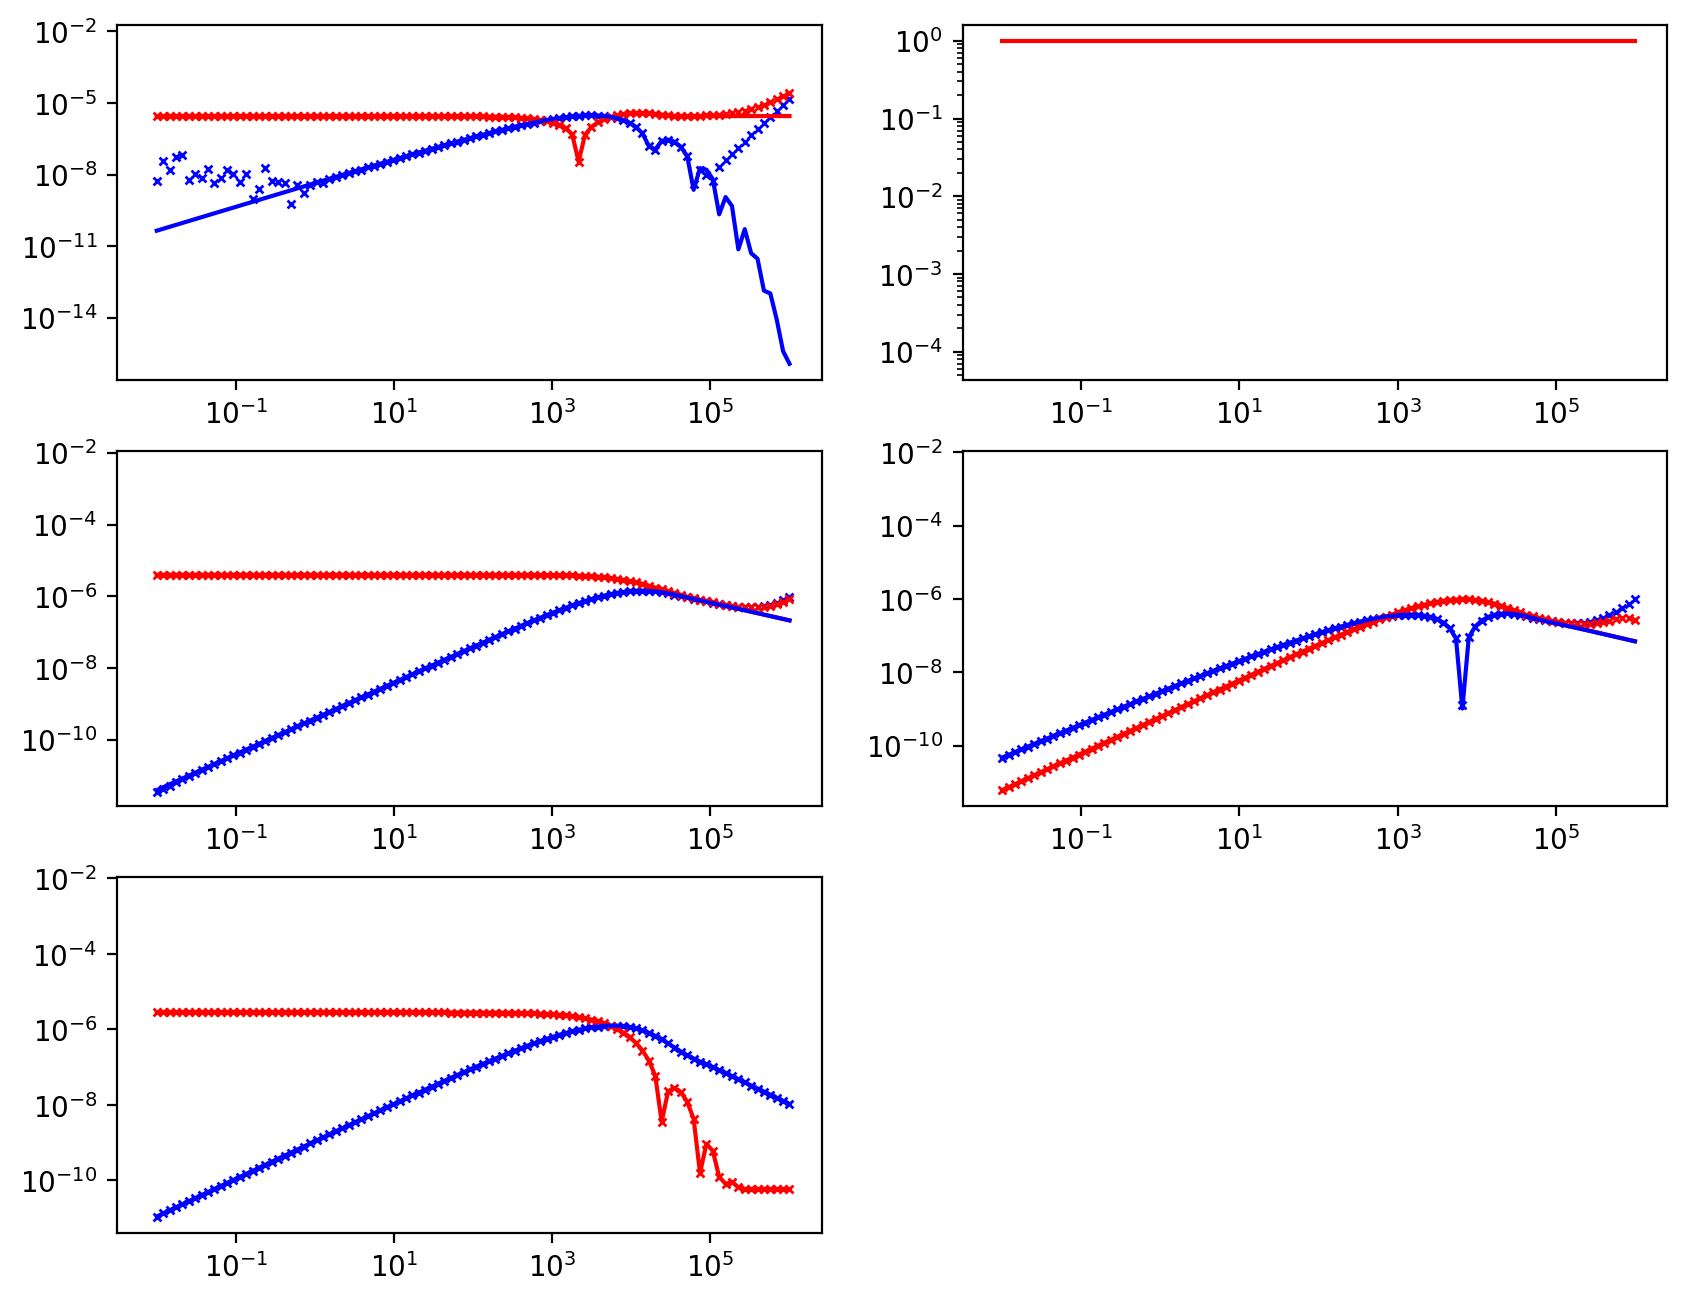

In [537]:
a = w1dem(EmB)

In [59]:
# numerical = em1dbasetdem(EmB) 
# numerical = numerical["DANS"]
# print(numerical[:, 3])    

In [214]:
a = [4,3,5]

In [215]:
if a in [1,2,3]:
    print("success!")
else:
    print("false...")

false...
